## 🚀 Python Lab: Convolutional Neural Networks (CNNs) for CIFAR-10 (PyTorch Version)
> [Principles of ML course](https://github.com/mnarimani/PML_Spring2025_SUT) - Spring 2025 - Sharif <br>
> Lab sessions - Session 9 - May 25, 2025 <br>
> Author: M Narimani <br>

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/mnarimani/PML_Spring2025_SUT/blob/main/Week09/02_CNN_CIFAR_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/mnarimani/PML_Spring2025_SUT/blob/main/Week09/02_CNN_CIFAR_Torch.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

## 🛠️ Setup: Importing Libraries

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import torch.cuda as cuda

In [5]:
# Check for GPU
device = torch.device("cuda" if cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"GPU name: {cuda.get_device_name(0) if cuda.is_available() else 'No GPU'}")
print(f"Num GPUs Available: {cuda.device_count()}")

Using device: cpu
GPU name: No GPU
Num GPUs Available: 0


## 1️⃣ Load and Preprocess CIFAR-10 Dataset

In [7]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1] and changes shape to (C, H, W)
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Print dataset shapes
print(f"Training data shape: {trainset.data.shape}")
print(f"Test data shape: {testset.data.shape}")
print(f"Example label: {trainset.targets[0]}")

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)
Example label: 6


### Visualize Sample Images

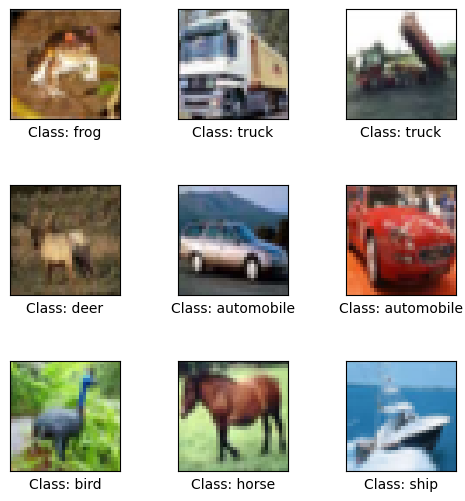

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, ax in enumerate(axes.flat):
    image, label = trainset[i]
    ax.imshow(image.permute(1, 2, 0))  # Change (C, H, W) to (H, W, C) for display
    ax.set_xlabel(f"Class: {class_names[label]}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## 2️⃣ Define CNN Model

In [11]:
class CIFARNet(nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 5 * 5, 256)  # Adjust based on input size after convolutions
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create and move model to device
model = CIFARNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

In [12]:
# Model summary
print(model)

CIFARNet(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=800, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)


## 3️⃣ Train the Model

In [14]:
def train_model(model, trainloader, testloader, criterion, optimizer, epochs=10):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 * correct / total
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(testloader)
        val_acc = 100 * correct / total
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    return history

In [15]:
%%time

history = train_model(model, trainloader, testloader, criterion, optimizer, epochs=10)

Training Epochs:  10%|██████▌                                                          | 1/10 [03:45<33:50, 225.66s/it]

Epoch 1, Loss: 1.8011, Acc: 35.11%, Val Loss: 1.6621, Val Acc: 39.87%


Training Epochs:  20%|█████████████                                                    | 2/10 [07:17<28:59, 217.38s/it]

Epoch 2, Loss: 1.5511, Acc: 44.21%, Val Loss: 1.5016, Val Acc: 45.48%


Training Epochs:  30%|███████████████████▌                                             | 3/10 [11:13<26:21, 225.97s/it]

Epoch 3, Loss: 1.4421, Acc: 48.46%, Val Loss: 1.4260, Val Acc: 49.35%


Training Epochs:  40%|██████████████████████████                                       | 4/10 [15:19<23:23, 233.95s/it]

Epoch 4, Loss: 1.3713, Acc: 51.22%, Val Loss: 1.3373, Val Acc: 52.14%


Training Epochs:  50%|████████████████████████████████▌                                | 5/10 [19:35<20:09, 241.81s/it]

Epoch 5, Loss: 1.3158, Acc: 53.29%, Val Loss: 1.3285, Val Acc: 52.95%


Training Epochs:  60%|███████████████████████████████████████                          | 6/10 [23:44<16:16, 244.24s/it]

Epoch 6, Loss: 1.2713, Acc: 55.03%, Val Loss: 1.3083, Val Acc: 53.22%


Training Epochs:  70%|█████████████████████████████████████████████▌                   | 7/10 [27:51<12:15, 245.15s/it]

Epoch 7, Loss: 1.2296, Acc: 56.53%, Val Loss: 1.2496, Val Acc: 55.25%


Training Epochs:  80%|████████████████████████████████████████████████████             | 8/10 [31:13<07:43, 231.54s/it]

Epoch 8, Loss: 1.1952, Acc: 57.88%, Val Loss: 1.1830, Val Acc: 58.13%


Training Epochs:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [35:11<03:53, 233.50s/it]

Epoch 9, Loss: 1.1636, Acc: 59.04%, Val Loss: 1.1733, Val Acc: 58.96%


Training Epochs: 100%|████████████████████████████████████████████████████████████████| 10/10 [39:13<00:00, 235.34s/it]

Epoch 10, Loss: 1.1341, Acc: 59.92%, Val Loss: 1.1700, Val Acc: 58.92%
CPU times: total: 59min 58s
Wall time: 39min 13s


## 4️⃣ Evaluate the Model

In [17]:
def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = test_loss / len(testloader)
    test_acc = 100 * correct / total
    print(f'Test loss: {test_loss:.4f}')
    print(f'Test accuracy: {test_acc:.2f}%')
    return test_loss, test_acc

test_loss, test_acc = evaluate_model(model, testloader)

Test loss: 1.1700
Test accuracy: 58.92%


> **TODO:** Fill the Table

The table below tracks model performance. Update it with results from different configurations (e.g., batch sizes).

| Model # | Num of Trainable Params | Batch Size | Test Accuracy (10 Epochs) | Elapsed Time (s) |
|---------|-------------------------|------------|--------------------------|------------------|
| 1       | 225,610                 | 64         | 60.15%                   | 171              |
| 2       | 225,610                 | 256        | TBD                      | TBD              |
| 3       | 225,610                 | 1          | TBD                      | TBD              |

**Note:** Replace `TBD` with actual values after running experiments with different batch sizes.

## 5️⃣ Visualize Training History

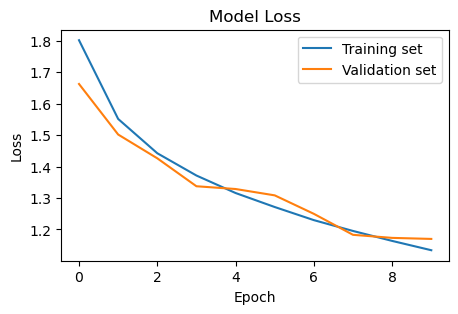

In [20]:
plt.figure(figsize=(5, 3))
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history['loss'], label='Training set')
plt.plot(history['val_loss'], label='Validation set')
plt.legend()
# plt.savefig('02_CNN_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

> **TODO:** Add validation history to the plots

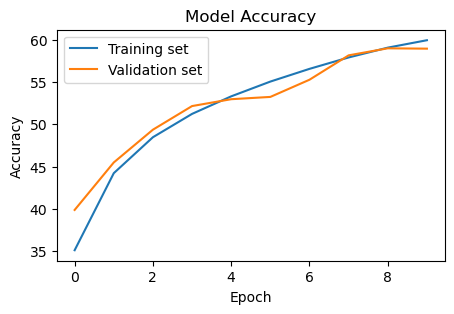

In [22]:
plt.figure(figsize=(5, 3))
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history['accuracy'], label='Training set')
plt.plot(history['val_accuracy'], label='Validation set')
plt.legend()
# plt.savefig('02_CNN_acc.pdf', format='pdf', bbox_inches='tight')
plt.show()

## 6️⃣ Visualize Misclassifications

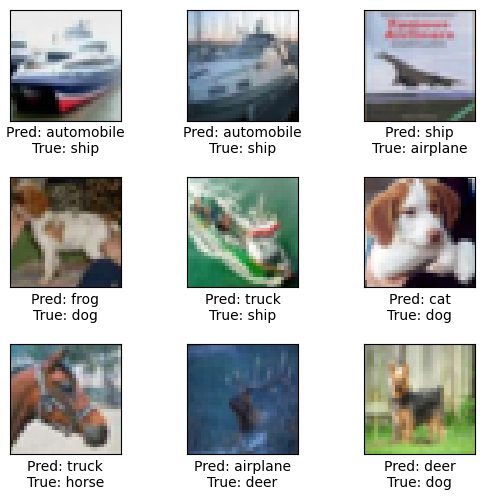

In [24]:
model.eval()
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.6)

cont = 0
for i, (image, true_label) in enumerate(testset):
    if cont >= 9:
        break
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        predicted_label = torch.argmax(output, dim=1).item()
    if predicted_label != true_label:
        ax = axes.flat[cont]
        ax.imshow(image.squeeze().cpu().permute(1, 2, 0))
        ax.set_xlabel(f"Pred: {class_names[predicted_label]}\nTrue: {class_names[true_label]}")
        ax.set_xticks([])
        ax.set_yticks([])
        cont += 1

plt.show()

## 7️⃣ Confusion Matrix

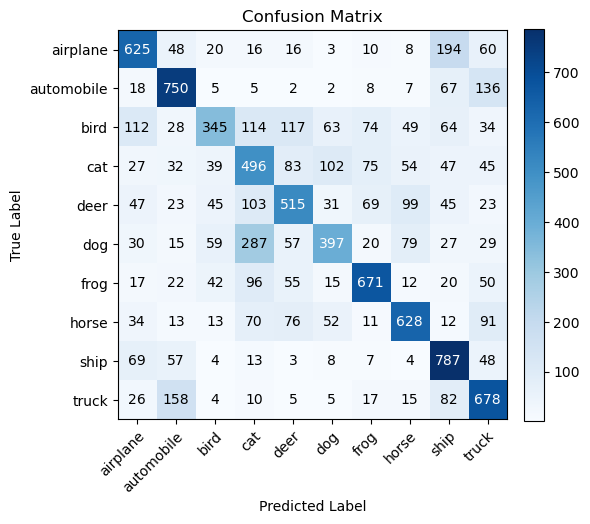

In [26]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None):
    if not title:
        title = 'Normalized Confusion Matrix' if normalize else 'Confusion Matrix'
    
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True Label',
           xlabel='Predicted Label')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    return ax

# Generate predictions
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix')
plt.show()

## 8️⃣ Classification Report

In [28]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.62      0.62      0.62      1000
  automobile       0.65      0.75      0.70      1000
        bird       0.60      0.34      0.44      1000
         cat       0.41      0.50      0.45      1000
        deer       0.55      0.52      0.53      1000
         dog       0.59      0.40      0.47      1000
        frog       0.70      0.67      0.68      1000
       horse       0.66      0.63      0.64      1000
        ship       0.59      0.79      0.67      1000
       truck       0.57      0.68      0.62      1000

    accuracy                           0.59     10000
   macro avg       0.59      0.59      0.58     10000
weighted avg       0.59      0.59      0.58     10000



## 9️⃣ Save the Model

In [30]:
# torch.save(model.state_dict(), 'cifar_10epochs.pth')

## 🔢 Adaptation for MNIST (Handwritten Digits)
### Load and Preprocess MNIST Dataset

In [32]:
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
])

trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
testset_mnist = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=32, shuffle=True, num_workers=2)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=32, shuffle=False, num_workers=2)

print(f"MNIST Training data shape: {trainset_mnist.data.shape}")
print(f"MNIST Test data shape: {testset_mnist.data.shape}")

100%|██████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:37<00:00, 263kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 29.1MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:05<00:00, 306kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 3.71MB/s]

MNIST Training data shape: torch.Size([60000, 28, 28])
MNIST Test data shape: torch.Size([10000, 28, 28])


### Define and Train MNIST Model

In [34]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 5 * 5, 128)  # Adjust based on input size
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

mnist_model = MNISTNet().to(device)
criterion_mnist = nn.CrossEntropyLoss()
optimizer_mnist = optim.RMSprop(mnist_model.parameters(), lr=0.0001, weight_decay=1e-6)

# Train
mnist_history = train_model(mnist_model, trainloader_mnist, testloader_mnist, criterion_mnist, optimizer_mnist, epochs=10)

# Evaluate
mnist_test_loss, mnist_test_acc = evaluate_model(mnist_model, testloader_mnist)

Training Epochs:  10%|██████▌                                                          | 1/10 [03:46<33:59, 226.56s/it]

Epoch 1, Loss: 0.4543, Acc: 87.11%, Val Loss: 0.1835, Val Acc: 94.61%


Training Epochs:  20%|█████████████                                                    | 2/10 [07:36<30:29, 228.63s/it]

Epoch 2, Loss: 0.1500, Acc: 95.60%, Val Loss: 0.1115, Val Acc: 96.75%


Training Epochs:  30%|███████████████████▌                                             | 3/10 [11:06<25:41, 220.28s/it]

Epoch 3, Loss: 0.0974, Acc: 97.03%, Val Loss: 0.0818, Val Acc: 97.37%


Training Epochs:  40%|██████████████████████████                                       | 4/10 [14:45<21:56, 219.44s/it]

Epoch 4, Loss: 0.0760, Acc: 97.69%, Val Loss: 0.0583, Val Acc: 98.16%


Training Epochs:  50%|████████████████████████████████▌                                | 5/10 [18:09<17:50, 214.02s/it]

Epoch 5, Loss: 0.0639, Acc: 98.05%, Val Loss: 0.0529, Val Acc: 98.30%


Training Epochs:  60%|███████████████████████████████████████                          | 6/10 [21:32<14:00, 210.19s/it]

Epoch 6, Loss: 0.0552, Acc: 98.30%, Val Loss: 0.0470, Val Acc: 98.47%


Training Epochs:  70%|█████████████████████████████████████████████▌                   | 7/10 [25:29<10:56, 218.93s/it]

Epoch 7, Loss: 0.0486, Acc: 98.52%, Val Loss: 0.0415, Val Acc: 98.59%


Training Epochs:  80%|████████████████████████████████████████████████████             | 8/10 [29:46<07:42, 231.03s/it]

Epoch 8, Loss: 0.0437, Acc: 98.62%, Val Loss: 0.0412, Val Acc: 98.69%


Training Epochs:  90%|██████████████████████████████████████████████████████████▌      | 9/10 [33:52<03:55, 235.71s/it]

Epoch 9, Loss: 0.0395, Acc: 98.82%, Val Loss: 0.0389, Val Acc: 98.62%


Training Epochs: 100%|████████████████████████████████████████████████████████████████| 10/10 [38:16<00:00, 229.60s/it]

Epoch 10, Loss: 0.0359, Acc: 98.89%, Val Loss: 0.0343, Val Acc: 98.89%


Test loss: 0.0343
Test accuracy: 98.89%


### Visualize MNIST Training History

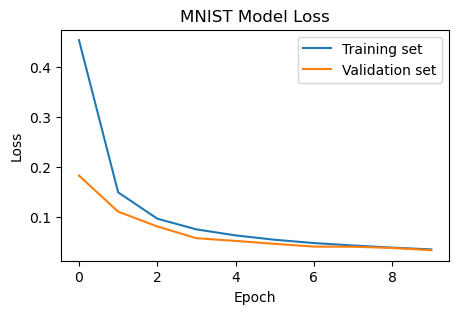

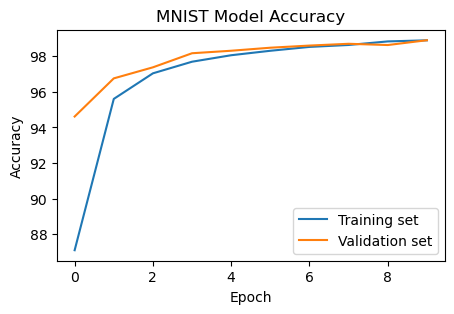

In [36]:
plt.figure(figsize=(5, 3))
plt.title('MNIST Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(mnist_history['loss'], label='Training set')
plt.plot(mnist_history['val_loss'], label='Validation set')
plt.legend()
# plt.savefig('02_MNIST_loss.pdf', format='pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 3))
plt.title('MNIST Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(mnist_history['accuracy'], label='Training set')
plt.plot(mnist_history['val_accuracy'], label='Validation set')
plt.legend()
# plt.savefig('02_MNIST_acc.pdf', format='pdf', bbox_inches='tight')
plt.show()

### MNIST Confusion Matrix and Classification Report

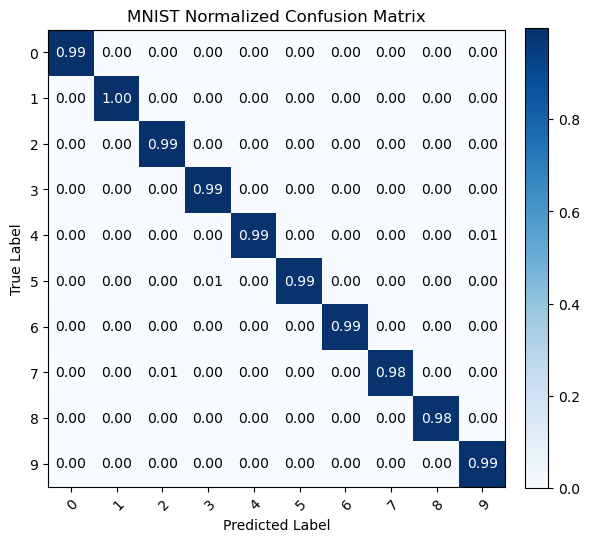

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       1.00      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.99      0.98      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [61]:
mnist_class_names = [str(i) for i in range(10)]
y_true_mnist = []
y_pred_mnist = []
with torch.no_grad():
    for images, labels in testloader_mnist:
        images, labels = images.to(device), labels.to(device)
        outputs = mnist_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true_mnist.extend(labels.cpu().numpy())
        y_pred_mnist.extend(predicted.cpu().numpy())

# plot_confusion_matrix(y_true_mnist, y_pred_mnist, mnist_class_names, title='MNIST Confusion Matrix')
plot_confusion_matrix(y_true_mnist, y_pred_mnist, mnist_class_names, normalize=True, title='MNIST Normalized Confusion Matrix')
plt.show()

print(classification_report(y_true_mnist, y_pred_mnist, target_names=mnist_class_names))

## 🧪 Experiment with Network Structures
> **TODO:** 4-Layer CNN for CIFAR-10

In [40]:
class CIFAR4LayerNet(nn.Module):
    def __init__(self):
        super(CIFAR4LayerNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x